In [1]:
# ==============================================================================
# LANGKAH 0: IMPORT SEMUA LIBRARY YANG DIBUTUHKAN
# ==============================================================================
import pandas as pd
import numpy as np
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import logging
from sqlalchemy import create_engine
from datetime import datetime

# Menyembunyikan output log yang 'berisik' dari Prophet
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)


c:\MIA\Code\Anaconda3\envs\prophet-final-test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

# ==============================================================================
# LANGKAH 1: PENGATURAN VARIABEL UTAMA
# ==============================================================================
# Pilih jenis pangan yang ingin dianalisis
JENIS_PANGAN = 'bawang_merah'

# Variabel baru untuk 'tingkat'
TINGKAT = 'pedagang_eceran'

# Tentukan rentang tahun untuk data training
TAHUN_AWAL = 2025 # Diubah untuk contoh agar data lebih cukup
TAHUN_AKHIR = 2025

# Tentukan berapa hari ke depan untuk diprediksi
JUMLAH_HARI_PREDIKSI = 90

# Model yang digunakan
MODEL_PILIHAN = 'Prophet'

In [3]:
# ==============================================================================
# LANGKAH 2: MEMUAT DATA DARI DATABASE
# ==============================================================================
import pandas as pd
from sqlalchemy import create_engine

print("1. Menghubungkan ke database dan memuat data...")

# --- Pengaturan Koneksi Database ---
db_host = 'localhost'
db_user = 'root'
db_password = ''
db_name = 'db_dispanhan'
# ------------------------------------

try:
    # Membuat koneksi engine ke database menggunakan SQLAlchemy
    engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}")

    # Query untuk mengambil data yang relevan dari tabel tbl_analisis_harga
    # Menggunakan filter untuk 'jenis' dan 'tingkat'
    query = f"""
        SELECT tahun, bulan, tanggal, harga 
        FROM tbl_analisis_harga 
        WHERE jenis = '{JENIS_PANGAN}' AND tingkat = '{TINGKAT}'
    """
    
    # Membaca data langsung ke dalam DataFrame Pandas
    df = pd.read_sql(query, engine)
    
    print(f"Berhasil memuat {len(df)} baris data '{JENIS_PANGAN}' tingkat '{TINGKAT}' dari database.")

    # --- Bagian pemrosesan data ---
    
    # Konversi bulan dan buat kolom datetime 'ds'
    bulan_map = {
        'januari': 1, 'februari': 2, 'maret': 3, 'april': 4, 'mei': 5, 'juni': 6,
        'juli': 7, 'agustus': 8, 'september': 9, 'oktober': 10, 'november': 11, 'desember': 12
    }
    df['bulan'] = df['bulan'].astype(str).str.lower().map(bulan_map)
    df['ds'] = pd.to_datetime(df[['tahun', 'bulan', 'tanggal']].rename(columns={'tahun': 'year', 'bulan': 'month', 'tanggal': 'day'}))

    # Filter data berdasarkan rentang tahun yang telah ditentukan
    df_filtered = df[
        (df['ds'].dt.year >= TAHUN_AWAL) &
        (df['ds'].dt.year <= TAHUN_AKHIR)
    ].copy()

    # Siapkan kolom 'y' dan urutkan dataframe
    df_filtered = df_filtered.rename(columns={'harga': 'y'})
    df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce') # Ubah harga ke numerik
    df_filtered.dropna(subset=['y'], inplace=True) # Hapus baris jika harga tidak valid
    
    df_filtered = df_filtered.sort_values(by='ds').reset_index(drop=True)[['ds', 'y']]

except Exception as e:
    print(f"GAGAL terhubung atau memuat data: {e}")
    # Membuat dataframe kosong jika terjadi error agar sisa kode tidak berhenti total
    df_filtered = pd.DataFrame()

1. Menghubungkan ke database dan memuat data...
Berhasil memuat 184 baris data 'bawang_merah' tingkat 'pedagang_eceran' dari database.


In [4]:
# ==============================================================================
# LANGKAH 3: PENANGANAN OUTLIER (Peningkatan Akurasi #1)
# ==============================================================================
if not df_filtered.empty:
    print("\n2. Mendeteksi dan menangani outlier...")
    # Menggunakan metode Interquartile Range (IQR)
    Q1 = df_filtered['y'].quantile(0.25)
    Q3 = df_filtered['y'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_filtered[(df_filtered['y'] < lower_bound) | (df_filtered['y'] > upper_bound)]
    print(f"Ditemukan {len(outliers)} outlier.")

    # Mengganti outlier dengan NaN lalu menginterpolasi nilainya
    df_filtered.loc[(df_filtered['y'] < lower_bound) | (df_filtered['y'] > upper_bound), 'y'] = np.nan
    df_filtered['y'] = df_filtered['y'].interpolate(method='linear')
    print("Outlier telah ditangani dengan interpolasi.")
else:
    print("\nDataFrame kosong, langkah selanjutnya dilewati.")




2. Mendeteksi dan menangani outlier...
Ditemukan 0 outlier.
Outlier telah ditangani dengan interpolasi.


In [5]:
# ==============================================================================
# LANGKAH 4: HYPERPARAMETER TUNING (VERSI DINAMIS DAN AMAN)
# ==============================================================================
if not df_filtered.empty:
    print(f"\n3. Mencari parameter terbaik untuk model {MODEL_PILIHAN}...")
    
    data_duration_days = (df_filtered['ds'].max() - df_filtered['ds'].min()).days
    
    initial_days = int(data_duration_days * 0.7)
    period_days = int(initial_days * 0.2)
    horizon_days = int(initial_days * 0.2)
    
    if horizon_days == 0:
        horizon_days = 30
        
    initial_str = f'{initial_days} days'
    period_str = f'{period_days} days'
    horizon_str = f'{horizon_days} days'

    print(f"Durasi data: {data_duration_days} hari. Pengaturan CV dinamis: initial='{initial_str}', period='{period_str}', horizon='{horizon_str}'")

    if data_duration_days < (horizon_days * 2):
        print("\nPERINGATAN: Data terlalu pendek untuk proses tuning. Melewati tuning dan menggunakan parameter default.")
        best_params = {}
    else:
        param_grid = {
            'changepoint_prior_scale': [0.01, 0.1, 0.5],
            'seasonality_prior_scale': [1.0, 5.0, 10.0],
        }
        all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
        rmses = []

        for params in all_params:
            m = Prophet(**params)
            m.add_country_holidays(country_name='ID')
            m.fit(df_filtered)
            df_cv = cross_validation(m, initial=initial_str, period=period_str, horizon=horizon_str, parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            rmses.append(df_p['rmse'].values[0])

        best_params = all_params[np.argmin(rmses)]
        print(f"\nParameter terbaik ditemukan: {best_params}")
else:
    print("\nDataFrame kosong, langkah selanjutnya dilewati.")




3. Mencari parameter terbaik untuk model Prophet...
Durasi data: 183 hari. Pengaturan CV dinamis: initial='128 days', period='25 days', horizon='25 days'


02:09:38 - cmdstanpy - INFO - Chain [1] start processing
02:09:38 - cmdstanpy - INFO - Chain [1] done processing
02:09:40 - cmdstanpy - INFO - Chain [1] start processing
02:09:40 - cmdstanpy - INFO - Chain [1] done processing
02:09:43 - cmdstanpy - INFO - Chain [1] start processing
02:09:43 - cmdstanpy - INFO - Chain [1] done processing
02:09:45 - cmdstanpy - INFO - Chain [1] start processing
02:09:45 - cmdstanpy - INFO - Chain [1] done processing
02:09:47 - cmdstanpy - INFO - Chain [1] start processing
02:09:47 - cmdstanpy - INFO - Chain [1] done processing
02:09:49 - cmdstanpy - INFO - Chain [1] start processing
02:09:49 - cmdstanpy - INFO - Chain [1] done processing
02:09:51 - cmdstanpy - INFO - Chain [1] start processing
02:09:51 - cmdstanpy - INFO - Chain [1] done processing
02:09:53 - cmdstanpy - INFO - Chain [1] start processing
02:09:53 - cmdstanpy - INFO - Chain [1] done processing
02:09:55 - cmdstanpy - INFO - Chain [1] start processing
02:09:56 - cmdstanpy - INFO - Chain [1]


Parameter terbaik ditemukan: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


In [6]:
# ==============================================================================
# LANGKAH 5: TRAINING FINAL DAN PREDIKSI
# ==============================================================================
if not df_filtered.empty:
    print("\n4. Melatih model final dengan parameter terbaik dan membuat prediksi...")
    
    final_model = Prophet(**best_params)
    final_model.add_country_holidays(country_name='ID')
    final_model.fit(df_filtered)
    
    future = final_model.make_future_dataframe(periods=JUMLAH_HARI_PREDIKSI)
    forecast = final_model.predict(future)
else:
    print("\nDataFrame kosong, langkah selanjutnya dilewati.")



02:09:58 - cmdstanpy - INFO - Chain [1] start processing



4. Melatih model final dengan parameter terbaik dan membuat prediksi...


02:09:58 - cmdstanpy - INFO - Chain [1] done processing


5. Menampilkan grafik hasil akhir...


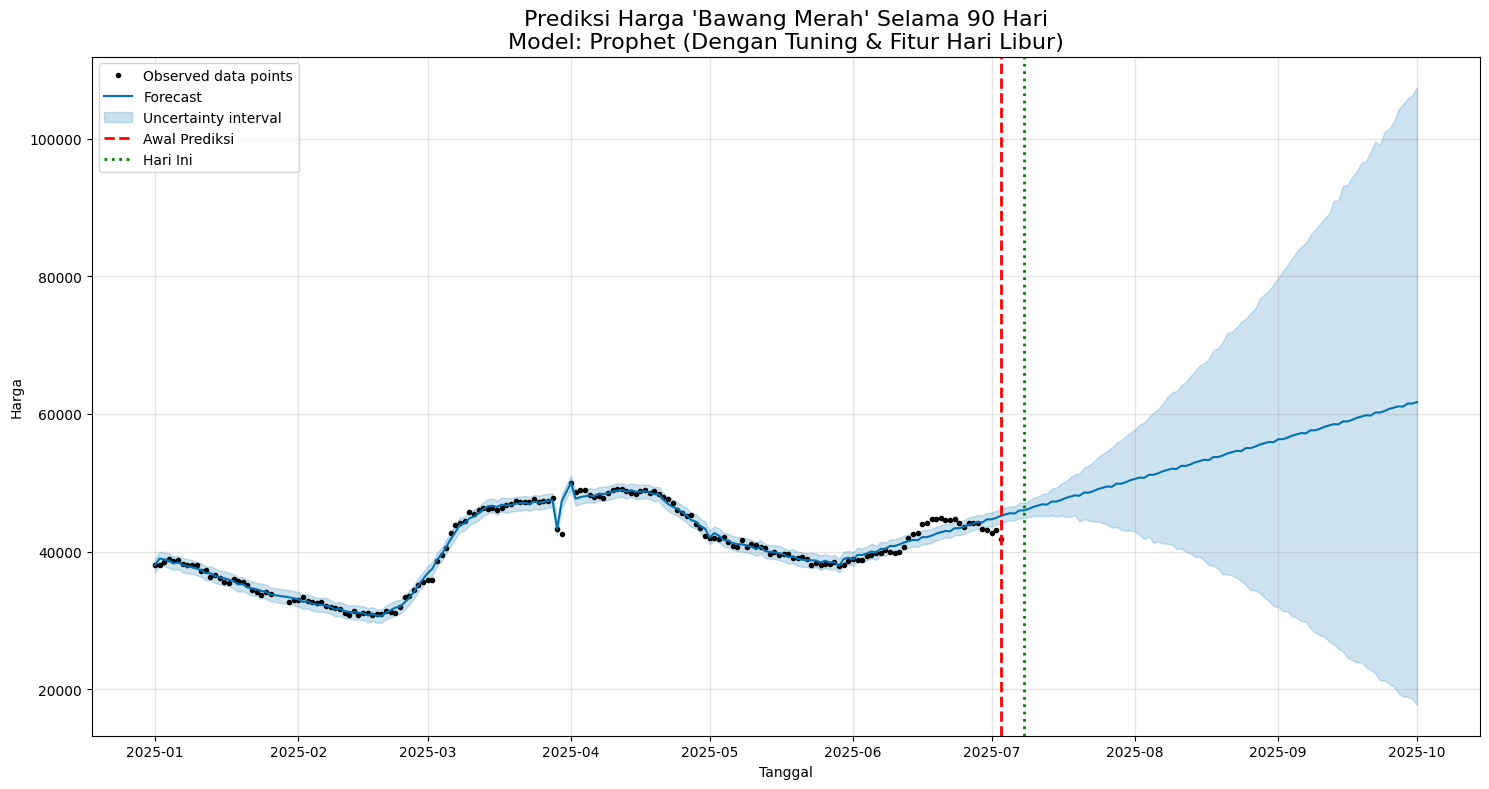

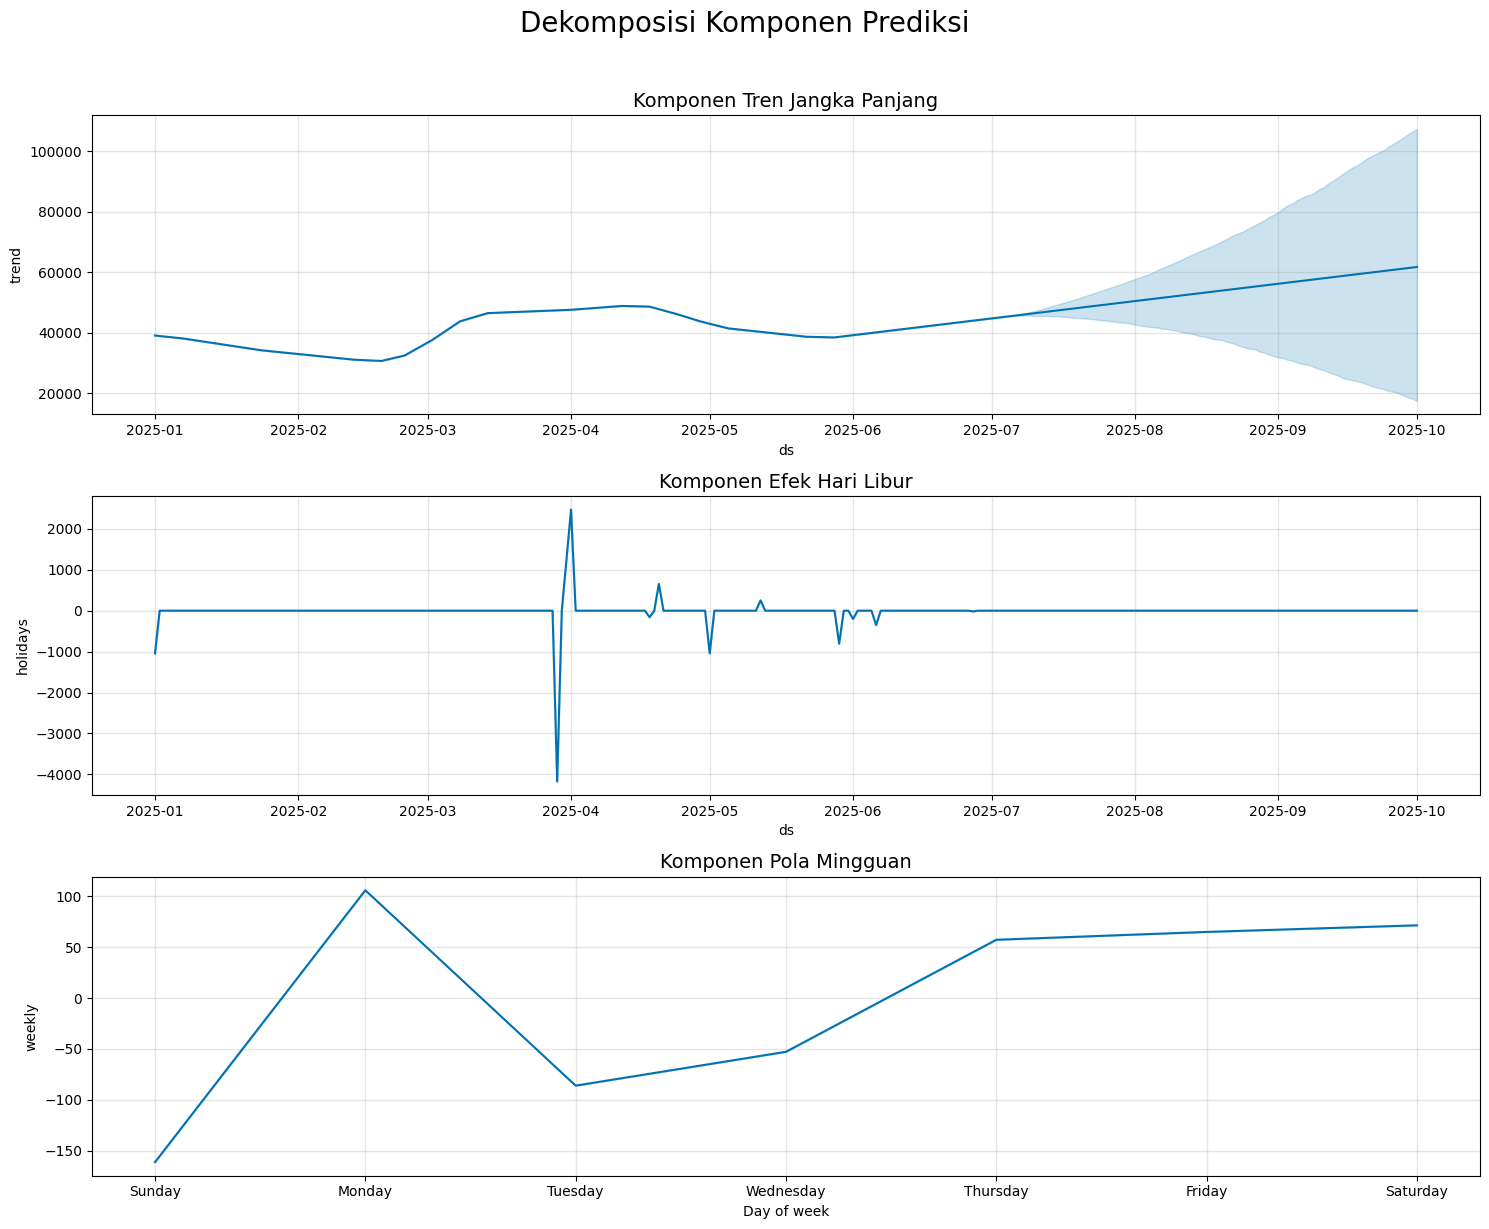


✅ Proses Selesai!


In [7]:
# ==============================================================================
# LANGKAH 6: VISUALISASI HASIL AKHIR (DENGAN JUDUL LENGKAP)
# ==============================================================================
if not df_filtered.empty:
    print("5. Menampilkan grafik hasil akhir...")
    
    judul_plot_utama = (
        f"Prediksi Harga '{JENIS_PANGAN.replace('_', ' ').title()}' Selama {JUMLAH_HARI_PREDIKSI} Hari\n"
        f"Model: {MODEL_PILIHAN} (Dengan Tuning & Fitur Hari Libur)"
    )
    
    fig1 = final_model.plot(forecast, figsize=(15, 8))
    ax = fig1.gca()
    ax.set_title(judul_plot_utama, size=16)
    ax.set_xlabel("Tanggal")
    ax.set_ylabel("Harga")
    ax.axvline(df_filtered['ds'].max(), color='red', linestyle='--', lw=2, label='Awal Prediksi')
    ax.axvline(datetime.now(), color='green', linestyle=':', lw=2, label='Hari Ini')
    ax.legend()
    plt.tight_layout()
    plt.show()

    fig2 = final_model.plot_components(forecast, figsize=(15, 12))
    
    axes = fig2.get_axes()
    axes[0].set_title('Komponen Tren Jangka Panjang', size=14)
    axes[1].set_title('Komponen Efek Hari Libur', size=14)
    axes[2].set_title('Komponen Pola Mingguan', size=14)
    
    fig2.suptitle("Dekomposisi Komponen Prediksi", size=20, y=1.02)
    plt.tight_layout()
    plt.show()

    print("\n✅ Proses Selesai!")
else:
    print("\nProses tidak bisa dilanjutkan karena tidak ada data yang dimuat.")